## Install

In [0]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
from torch.nn import functional as thf
import torchvision as tv

## Config

In [2]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Using {device}')

image_shape = (1, 28, 28)
latent_size = 128
hidden_size = 400
num_epochs = 30
batch_size = 128
learning_rate = 0.001


Using cuda


## Sparse MNIST Dataset

In [0]:
def create_loader(dataset, shuffle=True):
  return th.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=shuffle)

train_ds = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=True, transform=tv.transforms.ToTensor(),
    download=True)

test_ds = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=False, transform=tv.transforms.ToTensor(),
    download=True)

train_loader = create_loader(train_ds)
test_loader = create_loader(test_ds, shuffle=False)

In [0]:
# Eager approach; generates entire image upfront.
class TileImage:
  def __init__(self, tiles, tile_yxs, image_h, image_w):
    self._image_h = image_h
    self._image_w = image_w
    channels = tiles[0].shape[0]
    self._image = np.zeros((channels, image_h, image_w))
    for tile, (y, x) in zip(tiles, tile_yxs):
      tile_c, tile_h, tile_w = tile.shape
      self._image[:, y:y+tile_h, x:x+tile_w] = tile
      
  def get(self, y=0, x=0, height=None, width=None):
    r = (x + width) if width else self._image_w
    b = (y + height) if height else self._image_h
    return self._image[:, y:b, x:r]
  
  
import cv2

def resize(img, height, width):
  orig_img = img
  
  # Convert CHW <-> WHC for OpenCV
  img = img.transpose(2, 1, 0)
  img = cv2.resize(img, (height, width))
  if orig_img.ndim != img.ndim:
    img = np.expand_dims(img, -1)  # Add channel back.
  img = img.transpose(2, 1, 0)
  return img

### Visualizations

(1, 100, 200)


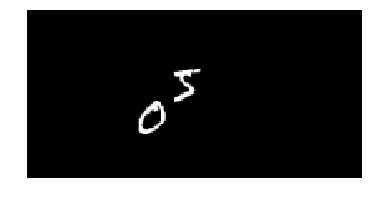

In [158]:
show_image(ti._image)
print(ti._image.shape)

(1, 50, 75)


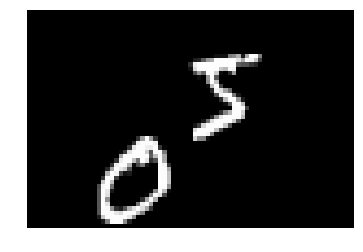

In [159]:
ti = TileImage([tile0, tile1], [(30, 80), (50, 60)], 100, 200)
patch = ti.get(25, 50, 50, 75)
show_image(patch)
print(patch.shape)

(1, 25, 30)


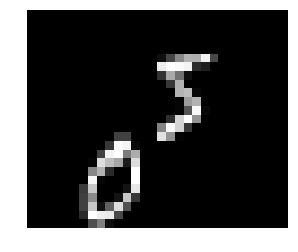

In [171]:
resized = resize(patch, 25, 30)
print(resized.shape)
show_image(resized)

### Loader

## Model

In [0]:
class VAE(nn.Module):
  def __init__(self, h_dim, z_dim):
    super(VAE, self).__init__()
    self.enc_h = nn.Sequential(
        nn.Conv2d(1, 8, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        nn.Conv2d(8, 16, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.Conv2d(16, 32, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        nn.Conv2d(32, 64, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.Conv2d(64, 128, 4),
        nn.LeakyReLU(),
    )
    h_dim = 128
    image_size = int(np.prod(image_shape))
    self.enc_mu = nn.Linear(h_dim, z_dim)
    self.enc_logvar = nn.Linear(h_dim, z_dim)
    self.dec_h = nn.Linear(z_dim, h_dim)
    self.dec = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64, 32, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 16, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 8, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(8, 4, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(4, 1, 5, padding=2),
        nn.Sigmoid(),
    )
    
  def encode(self, x):
    h = thf.relu(self.enc_h(x))
    h = h.view(h.shape[0], -1)
    return self.enc_mu(h), self.enc_logvar(h)
  
  def decode(self, z):
    h = self.dec_h(z)
    h = h.view(h.shape[0], -1, 1 , 1)
    x_reconst = self.dec(h)
    return x_reconst
  
  def decode_np(self, z_np):
    if z_np.ndim < 4:
      np.expand_dims(z_np, axis=0)
    z = th.from_numpy(z_np).to(device)
    return self.decode(z)
  
  def sample_normal(self, mu, logvar):
    std = th.exp(logvar / 2)
    x = th.randn_like(std)
    return mu + x * std
  
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.sample_normal(mu, logvar)
    x_reconst = self.decode(z)
    return x_reconst, mu, logvar
  
  def encode_decode(self, x):
    """Like forward(), but deterministically uses mean for z."""
    mu, logvar = self.encode(x)
    x_reconst = self.decode(mu)
    return x_reconst, mu, logvar

## Train

In [0]:
import collections
import copy

class ModelSnapshots(object):
  def __init__(self):
    self._snapshots = collections.OrderedDict()

  def snapshot(self, model, key):
    self._snapshots[key] = copy.deepcopy(model)
    
  def get(self, key):
    return self._snapshots[key]

In [0]:
def train(model, data_loader):
  model_snapshots = ModelSnapshots()
  optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

  num_steps = len(data_loader)
  for epoch in range(num_epochs):
    for step, (x, _) in enumerate(data_loader):
      x = x.to(device)
      x_reconst, mu, logvar = model(x)

      # Compute reconstruction loss and KL-divergence.
      # See Appendix B in VAE paper.
      reconst_loss = thf.binary_cross_entropy(x_reconst, x, reduction='sum')
      kl_div = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Backprop.
      loss = reconst_loss + kl_div
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Reconst loss: {reconst_loss.item():.4f}, '
          f'KL Div: {kl_div.item():.4f}')
    model_snapshots.snapshot(model, epoch)
  return model_snapshots

In [0]:
models_by_class = [VAE(hidden_size, latent_size).to(device) for _ in range(10)]

for i in range(10):
  print(f'---- Training class {i} ----')
  train(models_by_class[i], train_loader_by_class[i])

## Test

In [0]:
import math
      
def sample_images(model, num_samples=1):
  with th.no_grad():
    z = th.randn(num_samples, latent_size).to(device)
    images = model.decode(z).view(-1, 1, 28, 28)
  return images.cpu().numpy()

def visualize_images(images, title=None, sub_titles=None, rows=None, cols=None):
  s = images.shape
  if images.ndim == 4:
    rows = rows or 1
    cols = cols or int(math.ceil(s[0] / rows))
    images = np.reshape(images, (rows, cols, s[1], s[2], s[3]))
    n = s[0]
  elif images.ndim == 5:
    rows = rows or s[0]
    cols = cols or s[1]
    n = s[0] * s[1]
  assert rows * cols <= n
  
  images = images[:rows, :cols, ...]
  if images.shape[2] == 1:  # 1-dim channel
    images = images.squeeze(axis=2)
  fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 1.5 * rows),
                          gridspec_kw={'wspace':0, 'hspace':0})
  if title:
    fig.suptitle(title, y=1)
  for r in range(rows):
    for c in range(cols):
      i = r * cols + c
      image = images[r, c]
      subplot = axes[r, c] if rows > 1 else axes[c]
      subplot.imshow(image, cmap='gray', aspect='auto')
      subplot.axis('off')
      if sub_titles:
        subplot.title.set_text(sub_titles[i])
      
def show_image(image):
  image = image.squeeze()
  plt.imshow(image, cmap='gray')
  plt.axis('off')

## Future Work

Things to try


*   Verify that BCE gives reconstruction log_prob
*   Adjust log_prob by mean on the train set, for that class. Some classes seem harder than others to model
*   Improve encoder-decoders. Reconstructions in-class aren't very good yet
*   Play with latent size
*   Play with other prob density estimates (e.g. account for latent likelihood)


---

Longer term things to try


*   Train 1 model on all classes instead of 1 per class. Provide class as input. This models p(x, y) instead of p(x).





## Save model

In [0]:
th.save(model.state_dict(), '/tmp/vae.ckpt')